# Introduction to Machine Learning 2021 - Final Project

## Submission details - Group 2:
- Ben Mali - 204148225
- Doron Shapira - 316208032 
- Ariel Regev - 321776627

## Quick Access

- <a href="#Import-libraries">Import libraries</a>
- <a href="#Exploration">Explortaion</a>
- <a href="#Pre-Processing">Pre Processing</a> 
- <a href="#Evaluation">Evaluation</a>
- <a href="#Models">Models</a>
- <a href="#Test-prediction">Test prediction</a>
- <a href="#Additional-attempt">Additional attempt</a>
- <a href="#Weighted-accuracy">Weighted accuracy</a>

# Import libraries

In [2]:
import numpy as np
import pandas as pd

# ML Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

###############
# from sklearn.preprocessing import Imputer , Normalizer , scale
# from sklearn.cross_validation import train_test_split , StratifiedKFold

import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
# Evaluation
from sklearn import metrics
from outliers import remove_outlier_stddev
from sklearn.feature_selection import RFECV ##########

# Visualisation

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from helper.feature_classfier import classify_features

C:\Users\Ariel\anaconda3\python.exe
3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)


In [3]:
def get_non_binary_cols(data):
    """
    get the indexes of the non-binary, numeric columns
    we will use this function to scale on these columns
    :return: list of indexes
    """
    num_cols = list(map(str.strip, data._get_numeric_data().columns))[:-1]
    indexes = []

    for feature in data[num_cols]:
        values = [x != 1 and x != 0 and not pd.isnull(x) for x in data[feature]]
        if any(values):
            indexes.append(feature)
    return indexes


def classify_features(data):
    """
    get classifications for our data set
    :return: dictionary of class: [list of features that belong to this class]
    """
    classes = {"categorical": [],
               "binary": [],
               "numerical": []
               }
    features = set(data.columns)
    num_cols = list(map(str.strip, data._get_numeric_data().columns))[:-1]
    classes["categorical"] = sorted(features - set(num_cols))
    indexes = []
    for feature in data[num_cols]:
        values = [x != 1 and x != 0 and not pd.isnull(x) for x in data[feature]]
        if any(values):
            indexes.append(feature)
    classes["numerical"] = indexes
    classes["binary"] = sorted(set(num_cols) - set(indexes))
    return classes


# Import train data

In [4]:
train_set = pd.read_csv('train.csv')

# Exploration

#### We'll explore the data by showing statistics, data types, and correlations among the features.
#### In addition, we'll plot some visualization to better understend the data.

In [44]:
train_set.head()  #  showing the first 5 rows

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,label
0,1.0,a,-1d,0.828866,216.0,4.846091,K,50.0,0,161.714226,...,n,2.0,414.0,0.0,S,2.191401,a8,NaN,15.921017,1
1,8.0,a,-1d,8.981168,46.0,7.324911,A,270.0,0,328.559851,...,n,3.0,63.0,0.0,M,3.811778,a8,NaN,47.567140,0
2,1.0,a,-1d,1.458061,3304.0,7.548887,D,200.0,1,298.775554,...,n,1.0,218.0,0.0,M,4.284457,a4,NaN,10.522228,0
3,1.0,b,-1d,2.753682,212.0,8.200746,E,170.0,0,285.342907,...,y,2.0,NaN,0.0,D,4.680751,a7,NaN,21.185050,0
4,1.0,unknown,-1d,4.496872,1050.0,5.071094,B,260.0,1,328.464688,...,n,3.0,293.0,0.0,S,2.740114,a5,NaN,47.491164,0


In [6]:
train_set.tail()  # showing the last 5 rows

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,label
21926,1.0,unknown,-1d,9.234068,228.0,6.497949,G,200.0,1,298.387445,...,n,2.0,257.0,0.0,S,3.036520,a5,NaN,23.647446,0
21927,3.0,a,202d,1.425130,829.0,4.459834,K,270.0,0,330.998210,...,n,0.0,196.0,0.0,S,2.108740,a1,B,17.079316,1
21928,1.0,a,-1d,7.656161,296.0,6.688392,A,80.0,1,210.458322,...,n,3.0,NaN,0.0,M,4.083415,a5,NaN,26.412485,0
21929,2.0,unknown,-1d,4.016924,57.0,5.486059,B,90.0,1,220.485053,...,n,2.0,404.0,0.0,S,2.587831,a5,NaN,-2.056748,0
21930,1.0,a,-1d,1.026590,54.0,6.392427,G,100.0,1,231.026259,...,n,2.0,NaN,0.0,M,3.535312,a7,NaN,44.396488,0


In [7]:
print('{} rows and {} columns'.format(train_set.shape[0], train_set.shape[1]))

21931 rows and 22 columns


#### showing some statistics about the data:

In [43]:
train_set.describe()

,0,3,4,5,7,8,9,10,11,13,14,15,17,20,label
count,21858.000000,21826.000000,21906.000000,21871.000000,21911.000000,21931.000000,21892.000000,21828.000000,21860.000000,21891.000000,17946.000000,21832.000000,21830.000000,21930.000000,21931.000000
mean,2.709443,4.204116,1383.256596,6.589936,157.450596,0.542429,256.617674,0.608164,268.845882,2.063816,276.022010,0.017314,3.647972,26.278887,0.178423
std,2.976380,3.752786,3030.087625,0.921664,83.121658,0.498208,71.635412,1.893069,183.952200,0.784205,274.575423,0.130442,0.746277,20.111219,0.382877
min,1.000000,-11.138786,-8019.000000,3.776680,10.000000,0.000000,-1.892158,0.000000,0.003898,0.000000,0.000000,0.000000,1.939095,-54.438941,0.000000
25%,1.000000,1.605409,80.000000,5.901285,80.000000,0.000000,209.751981,0.000000,119.317515,2.000000,108.000000,0.000000,3.036520,12.679984,0.000000
50%,2.000000,4.190917,470.000000,6.517118,160.000000,1.000000,277.786998,0.000000,242.093814,2.000000,191.000000,0.000000,3.535312,26.477637,0.000000
75%,3.000000,6.811247,1472.750000,7.246177,210.000000,1.000000,306.584649,0.000000,388.855035,3.000000,342.000000,0.000000,4.150667,39.945262,0.000000
max,51.000000,17.647593,102127.000000,10.303540,310.000000,1.000000,347.191571,41.000000,1081.031042,3.000000,4918.000000,1.000000,7.141043,102.590418,1.000000


#### counting how many nulls we have in the data:

In [9]:
train_set.isnull().sum()

0           73
1           89
2           56
3          105
4           25
5           60
6          145
7           20
8            0
9           39
10         103
11          71
12          13
13          40
14        3985
15          99
16          10
17         101
18          84
19       17681
20           1
label        0
dtype: int64

#### showing the percentage of null values in each column:

In [10]:
headers_train = [str(i) for i in range(21)]
print("The % of null values in each column is:\n", str((1-train_set.count()/len(train_set))*100))

The % of null values in each column is:
 0         0.332862
1         0.405818
2         0.255346
3         0.478774
4         0.113994
5         0.273585
6         0.661165
7         0.091195
8         0.000000
9         0.177830
10        0.469655
11        0.323743
12        0.059277
13        0.182390
14       18.170626
15        0.451416
16        0.045598
17        0.460535
18        0.383019
19       80.621039
20        0.004560
label     0.000000
dtype: float64


we can see that column 19 has more than 80% of null values, and due to the fact that these values are categorical ones, is it harder to fill them.

### Exploring the numeric features:

In [48]:
numeric_features = classify_features(train_set)['numerical']
train_set_numeric = train_set[numeric_features]
train_set_numeric.head()

,0,3,4,5,7,9,10,11,13,14,17,20
0,1.0,0.828866,216.0,4.846091,50.0,161.714226,0.0,85.964376,2.0,414.0,2.191401,15.921017
1,8.0,8.981168,46.0,7.324911,270.0,328.559851,0.0,294.552881,3.0,63.0,3.811778,47.567140
2,1.0,1.458061,3304.0,7.548887,200.0,298.775554,0.0,317.615920,1.0,218.0,4.284457,10.522228
3,1.0,2.753682,212.0,8.200746,170.0,285.342907,0.0,181.773337,2.0,NaN,4.680751,21.185050
4,1.0,4.496872,1050.0,5.071094,260.0,328.464688,0.0,454.058222,3.0,293.0,2.740114,47.491164


#### showing some statistics about the numeric features:

In [11]:
train_set_numeric.describe()

,0,3,4,5,7,8,9,10,11,13,14,15,17,20,label
count,21858.000000,21826.000000,21906.000000,21871.000000,21911.000000,21931.000000,21892.000000,21828.000000,21860.000000,21891.000000,17946.000000,21832.000000,21830.000000,21930.000000,21931.000000
mean,2.709443,4.204116,1383.256596,6.589936,157.450596,0.542429,256.617674,0.608164,268.845882,2.063816,276.022010,0.017314,3.647972,26.278887,0.178423
std,2.976380,3.752786,3030.087625,0.921664,83.121658,0.498208,71.635412,1.893069,183.952200,0.784205,274.575423,0.130442,0.746277,20.111219,0.382877
min,1.000000,-11.138786,-8019.000000,3.776680,10.000000,0.000000,-1.892158,0.000000,0.003898,0.000000,0.000000,0.000000,1.939095,-54.438941,0.000000
25%,1.000000,1.605409,80.000000,5.901285,80.000000,0.000000,209.751981,0.000000,119.317515,2.000000,108.000000,0.000000,3.036520,12.679984,0.000000
50%,2.000000,4.190917,470.000000,6.517118,160.000000,1.000000,277.786998,0.000000,242.093814,2.000000,191.000000,0.000000,3.535312,26.477637,0.000000
75%,3.000000,6.811247,1472.750000,7.246177,210.000000,1.000000,306.584649,0.000000,388.855035,3.000000,342.000000,0.000000,4.150667,39.945262,0.000000
max,51.000000,17.647593,102127.000000,10.303540,310.000000,1.000000,347.191571,41.000000,1081.031042,3.000000,4918.000000,1.000000,7.141043,102.590418,1.000000


#### plotting the numeric features' distribution:

add plots from tableau

#### plotting the boxplots for each numeric feature:

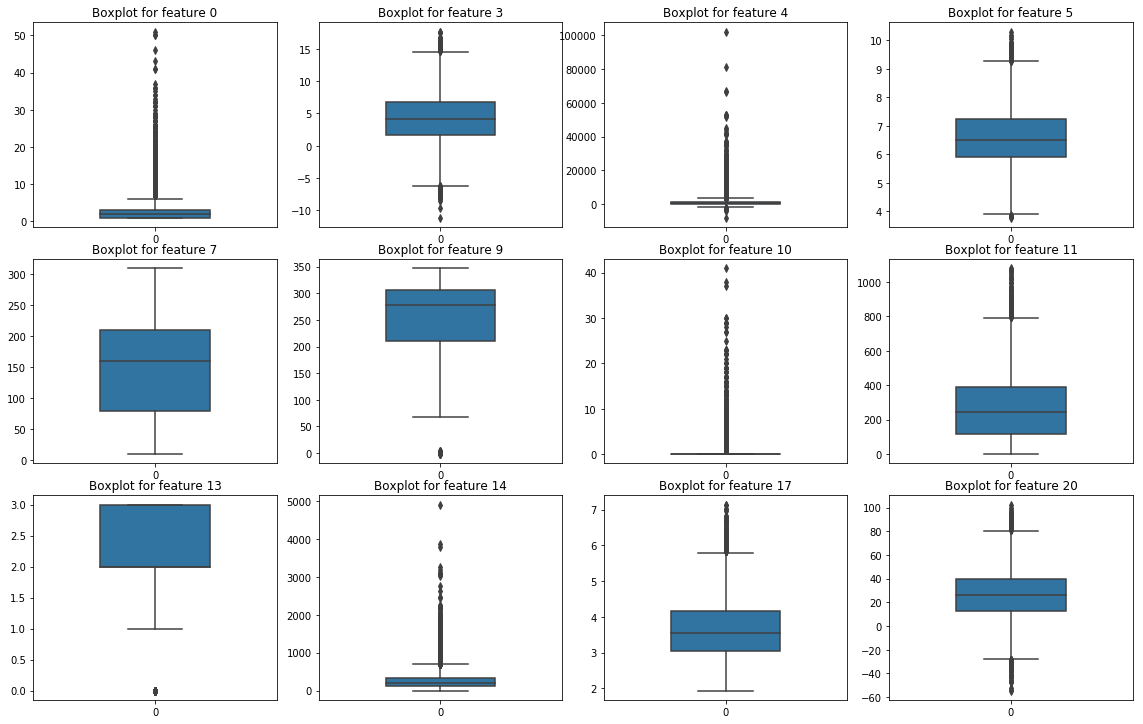

In [12]:
def box_plot(df):
    feature_classes = classify_features(df)
    numeric_features = feature_classes.get("numerical")
    f, axes = plt.subplots(3,4, figsize=(16,10))
    f.tight_layout()
    axes = axes.flatten()
    for i, feature in enumerate(numeric_features):
        sns.boxplot(data=df[feature], orient='v', width=0.45, ax=axes[i]).set_title('Boxplot for feature {}'.format(feature))
        
box_plot(train_set)


#### plotting the correlation matrix for the features:

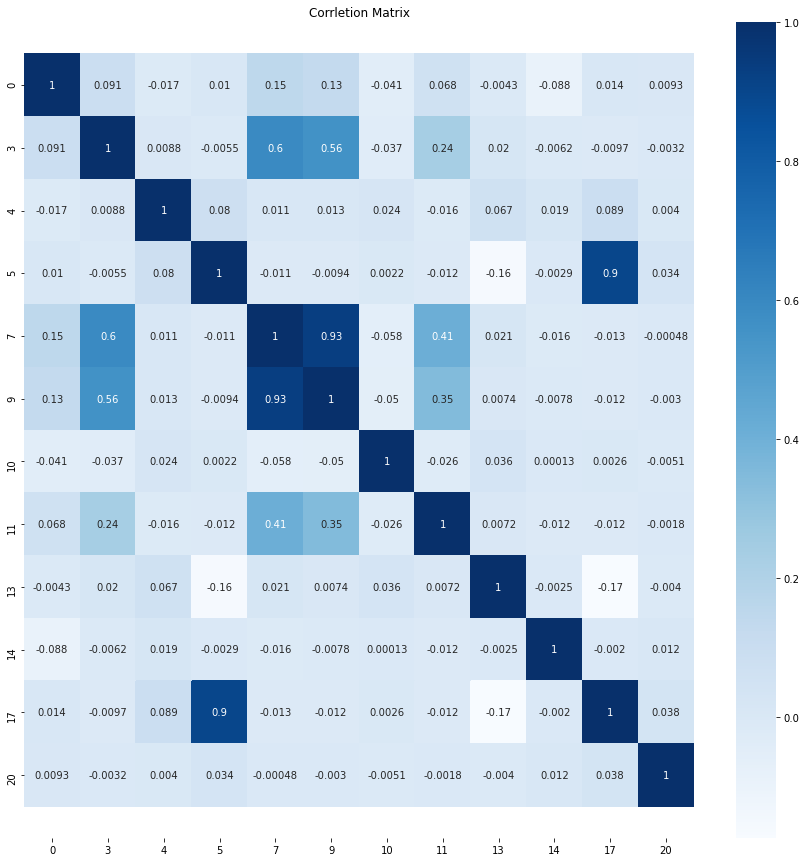

In [55]:
def cor_map(df):
    fig, ax =plt.subplots(figsize=(15, 15))
    corr_mat = df.corr()
    sns.heatmap(corr_mat, annot=True, cmap="Blues")
    bottom, top = plt.ylim()                                              
    bottom += 0.5                                                      
    top -= 0.5                                                      
    plt.ylim(bottom, top)                                                 
    ax.set_title('Corrletion Matrix')                                       
    plt.show()
    # Select upper triangle of correlation matrix
    upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.85
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    if to_drop != []:
        print ("Correlated Features:", to_drop)
cor_map(train_set_numeric)

### Exploring the categorical and binary features:

In [49]:
binary_features = classify_features(train_set)['binary']
train_set_binary = train_set[binary_features]
train_set_binary.head()

,15,8
0,0.0,0
1,0.0,0
2,0.0,1
3,0.0,0
4,0.0,1


In [50]:
cat_features = classify_features(train_set)['categorical']
train_set_cat = train_set[cat_features]
train_set_cat.head()

,1,12,16,18,19,2,6,label
0,a,n,S,a8,NaN,-1d,K,1
1,a,n,M,a8,NaN,-1d,A,0
2,a,n,M,a4,NaN,-1d,D,0
3,b,y,D,a7,NaN,-1d,E,0
4,unknown,n,S,a5,NaN,-1d,B,0


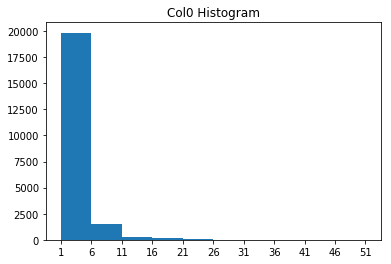

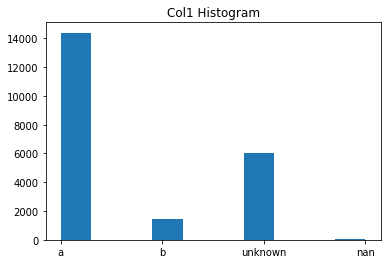

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

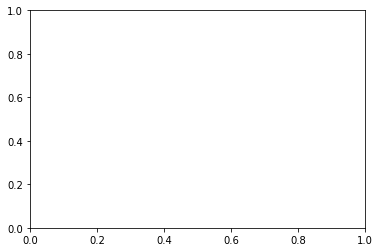

In [14]:
col_data = []
for col in range(train_set.shape[1] - 1):  # iterate over columns but label col
    col_data.append(train_set[str(col)].tolist())

#### col 0 ########
plt.hist(col_data[0])
plt.xticks([i for i in range(1,52, 5)])
plt.title("Col0 Histogram")
plt.show()

#### col 1 ########
plt.hist(col_data[1])
plt.title("Col1 Histogram")
plt.show()

#### col 2 ########
col2_dict = {}
for value in col_data[2]:
    if value in col2_dict:
        if not isinstance(value, float):
            col2_dict[value[:-1]] += 1
        else:
            col2_dict[value] += 1
    else:
        if not isinstance(value, float):
            col2_dict[value[:-1]] = 1
        else:
            col2_dict[value] = 1
histogram = sorted([(key, value) for key, value in col2_dict.items() ], key=lambda z: z[1], reverse=True)
x, y = zip(*histogram[:10])
plt.bar(x, y)
# plt.hist(col_data[2], bins=10)
plt.title("Col2 Histogram")
plt.show()


#### col 3 ########
plt.hist(col_data[3], bins=50)
plt.title("Col3 Histogram")
plt.show()

#### col 4 ########
plt.hist(col_data[4], bins=30)
plt.title("Col4 Histogram")
plt.show()


#### col 5 ########
plt.hist(col_data[5], bins=50)
plt.title("Col5 Histogram")
plt.show()


# #### col 6 ########
plt.hist(col_data[6])
plt.title("Col6 Histogram")
plt.show()


# #### col 7 ########
plt.hist(col_data[7], bins=100)
plt.title("Col7 Histogram")
plt.show()


# #### col 8 ########

col8_dict = {}
for value in col_data[8]:
    if value in col8_dict:
        col8_dict[value] += 1
    else:
        col8_dict[value] = 1

plt.bar(range(len(col8_dict)), list(col8_dict.values()), align='center')
plt.xticks(range(len(col8_dict)), list(col8_dict.keys()))

plt.title("Col8 Histogram")
plt.show()

# #### col 9 ########
plt.hist(col_data[9], bins=100)
plt.title("Col9 Histogram")
plt.show()


# #### col 10 ########
plt.hist(col_data[10],bins=50)
plt.title("Col10 Histogram")
plt.show()


# #### col 11 ########
plt.hist(col_data[11], bins=300)
plt.title("Col11 Histogram")
plt.show()


# #### col 12 ########

col12_dict = {}
for value in col_data[12]:
    if value in col12_dict:
        col12_dict[value] += 1
    else:
        col12_dict[value] = 1

plt.bar(range(len(col12_dict)), list(col12_dict.values()), align='center')
plt.xticks(range(len(col12_dict)), list(col12_dict.keys()))
plt.title("Col12 Histogram")
plt.show()

# #### col 13 ########

labels, counts = np.unique(col_data[13], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title("Col13 Histogram")
plt.show()

# #### col 14 ########
plt.hist(col_data[14], bins=300)
plt.title("Col14 Histogram")
plt.show()

# #### col 15 ########
labels, counts = np.unique(col_data[15], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title("Col15 Histogram")
plt.show()

# #### col 16 ########
labels, counts = np.unique(col_data[16], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title("Col16 Histogram")
plt.show()


# #### col 17 ########
plt.hist(col_data[17], bins=100)
plt.title("Col17 Histogram")
plt.show()


# #### col 18 ########
labels, counts = np.unique(list(map(lambda x: int(x[1:]) if type(x) == str else -1, col_data[18])), return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title("Col18 Histogram")
plt.show()

# #### col 19 ########
labels, counts = np.unique(col_data[19], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title("Col19 Histogram")
plt.show()


#### col 20 ########
plt.hist(col_data[20], bins=100)
plt.title("Col20 Histogram")
plt.show()

In [ ]:
x = [i for i in range(1, train_set.shape[1])]

print(train_set.describe())
correlation_matrix = train_set.corr()
cov_matrix = train_set.cov()
y = np.array([1, 1, 2, 2])
pred = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
metrics.auc(fpr, tpr)